In [1]:
%load_ext nb_black
%load_ext autoreload
%autoreload 2

<IPython.core.display.Javascript object>

In [34]:
import numpy as np
import matplotlib.pyplot as plt
import math
from util.plots import scatter_plot
from typing import List, Dict
from tqdm.notebook import tqdm

<IPython.core.display.Javascript object>

In [3]:
np.random.seed(seed=42)

CELL_DIMENSION = np.array([16, 16])
orientation = 60
scale = 10
rotation_matrix = np.array(
    [
        [math.cos(orientation), -math.sin(orientation)],
        [math.sin(orientation), math.cos(orientation)],
    ]
)

PHASES_PER_UNIT_DISTANCE = 1.0 / np.array([scale, scale])

<IPython.core.display.Javascript object>

In [5]:
def get_random_phase():
    active_phases = np.random.random(2)

    return active_phases

<IPython.core.display.Javascript object>

In [7]:
def compute_movement(displacement: np.ndarray, active_phases):
    phase_displacement = (
        np.matmul(rotation_matrix, displacement) * PHASES_PER_UNIT_DISTANCE
    )

    active_phases = active_phases + phase_displacement

    active_phases = np.round(active_phases, decimals=9)
    active_phases = np.mod(active_phases, 1.0)

    return active_phases

<IPython.core.display.Javascript object>

In [20]:
np.random.seed(seed=42)

orientation = 60
scale = 10
rotation_matrix = np.array(
    [
        [math.cos(orientation), -math.sin(orientation)],
        [math.sin(orientation), math.cos(orientation)],
    ]
)

PHASES_PER_UNIT_DISTANCE = 1.0 / np.array([scale, scale])

<IPython.core.display.Javascript object>

In [ ]:
NO_COLUMNS = 32
CELLS_PER_COLUMN = 16
sensory_layer_activity = np.zeros((NO_COLUMNS, CELLS_PER_COLUMN)) # A_t^in

In [25]:
NO_GRID_CELL_MODULES = 32
NO_GRID_CELLS_PER_AXIS = 16
GRID_MODULE_DIM = np.array([16, 16])
TOTAL_GRID_CELLS_PER_MOD = np.prod(GRID_MODULE_DIM)
location_layer_activity = np.zeros(
    (NO_GRID_CELL_MODULES, TOTAL_GRID_CELLS_PER_MOD, NO_COLUMNS, CELLS_PER_COLUMN)
)  # A_t^loc
# activation states:
# sense
# loc

<IPython.core.display.Javascript object>

In [44]:
dendrites_to_sense_layer = np.zeros(
    (NO_GRID_CELL_MODULES, TOTAL_GRID_CELLS_PER_MOD, NO_COLUMNS, CELLS_PER_COLUMN)
)  # D_c,d^in
dendrites_to_loc_layer = np.zeros((NO_COLUMNS, CELLS_PER_COLUMN))  # D_c,d^loc

# vector for active dendritic segments
# pi_t^in
# pi_t^loc
# dendritic threshold:
# sig^in
# sig^loc

<IPython.core.display.Javascript object>

### Algorithm

1. movement to update location layer
    - calculate new phase - input: displacement vector and old phase; applies translation by rotation and scaling + mod 1 --> outputs binary vector A_t,move^loc
    - if no movement is given, activate random location ???
2. predict sensory information from location layer output
    - predictions represented by pi_t^in = activity of distal dendritic segments - Eq2 in paper
        --> modularoty effect
3. calculate activity in sensory layer
    - all cells share same feedforward receptive fields (how are these fields initialised???
    - sensory features represented by sparse subset of mini-columns = W_t^in
    - if cell is predicted and in active mini-columns: activate cell and inhibit other cells in mini-column; else: all cells become active
    - - multiple cells can be active if predicted by location layer
    - formula uq: 6 for activation logic
4. update location layer based on sensory cues
    - location layer receiver input from sensory layer (in form of W_t^in???)
    - calculate overlap EQ 3 & 4
repeat because new movement is received

Learning:
- strenghtening between connections of both layer
- when new object is learned: location representation is randomly initialised (each object has its own location space = multiple objects can be represented at the same time because their representation has low probability of overlap
- sensory layer: random cell in each column will be active
- form reciprocal connections on one of their dendritic segments (d') (EQ 5 & 6)
--> if synapse exist it is unaffected otherwise it is formed

In [41]:
THRESHOLD = 10

<IPython.core.display.Javascript object>

In [65]:
dendrites = np.random.randint(2, size=dendrites_to_sense_layer.shape)
dendrites

array([[[[1, 1, 1, ..., 0, 0, 0],
         [0, 1, 0, ..., 0, 0, 0],
         [1, 0, 1, ..., 0, 0, 1],
         ...,
         [0, 0, 0, ..., 1, 1, 0],
         [0, 0, 1, ..., 0, 1, 0],
         [1, 0, 0, ..., 0, 0, 1]],

        [[0, 1, 1, ..., 1, 0, 0],
         [0, 1, 1, ..., 0, 0, 1],
         [0, 1, 1, ..., 1, 0, 1],
         ...,
         [0, 1, 1, ..., 1, 1, 1],
         [0, 1, 0, ..., 1, 0, 0],
         [0, 1, 0, ..., 1, 1, 0]],

        [[0, 0, 1, ..., 1, 0, 1],
         [0, 1, 1, ..., 0, 0, 1],
         [0, 1, 0, ..., 1, 0, 0],
         ...,
         [1, 1, 0, ..., 1, 0, 0],
         [1, 0, 1, ..., 0, 0, 1],
         [1, 0, 1, ..., 0, 1, 1]],

        ...,

        [[0, 1, 0, ..., 1, 1, 0],
         [0, 0, 1, ..., 0, 0, 1],
         [1, 1, 1, ..., 0, 0, 1],
         ...,
         [0, 1, 0, ..., 1, 0, 0],
         [1, 1, 0, ..., 0, 0, 0],
         [1, 0, 1, ..., 0, 0, 1]],

        [[1, 0, 1, ..., 1, 1, 0],
         [1, 0, 1, ..., 0, 1, 1],
         [1, 1, 0, ..., 0, 0, 1],
    

<IPython.core.display.Javascript object>

(32, 256, 32, 16)

<IPython.core.display.Javascript object>

In [51]:
active_cells = compute_active_cells(get_random_phases())
active_cells.shape

(32,)

<IPython.core.display.Javascript object>

In [ ]:
aa

In [78]:
indices = np.argwhere(dendrites == 1)
indices.shape

(2097074, 4)

<IPython.core.display.Javascript object>

In [50]:
def get_random_phases():
    active_phases = np.random.random((NO_GRID_CELL_MODULES, 2))

    return active_phases


def compute_active_cells(active_phases):
    active_cell_coordinates = np.floor(active_phases * CELL_DIMENSION).astype(int)

    cells_for_active_phases = np.ravel_multi_index(
        active_cell_coordinates.T, CELL_DIMENSION
    )

    return cells_for_active_phases


def learn_object(obj: List[Dict]):
    """
    obj: [{location: <displacement vector>, feature: <feature_vector>}, ...]

    """

    # generate random phases since location is not given before first iteration
    phases = get_random_phases()

    for sample in obj:

        location = sample["location"]
        feature = sample["feature"]

        active_grid_cell_indices = compute_active_cells(get_random_phases())

        # get overlap of phases and dendritic distal segments to predict cells
        overlap = np.logical_and(phases, dendrites_to_sense_layer)

<IPython.core.display.Javascript object>

In [30]:
get_random_phases().shape

(32, 2)

<IPython.core.display.Javascript object>

In [ ]:
x, y = np.unravel_index(active_cells, CELL_DIMENSION)
scatter_plot(x, y, lim=(0, 15))

In [367]:
def calculate_points_from_displacements(displacements):
    xs = [0]
    ys = [0]

    for i in range(len(displacements)):
        xs.append(xs[i] + displacements[i][0])
        ys.append(ys[i] + displacements[i][1])

    return xs, ys

<IPython.core.display.Javascript object>

In [ ]:
rnd_phase = get_random_phase()
active_cells = [compute_active_cells(rnd_phase)]

active_phase = rnd_phase
for dis in displacements:
    active_phase = compute_movement(dis, active_phase)
    active_cell = compute_active_cells(active_phase)

    active_cells.append(active_cell)

In [368]:
xs, ys = calculate_points_from_displacements(displacements)

<IPython.core.display.Javascript object>

In [369]:
indices = [i for i, x in enumerate(active_cells) if x == 91]

<IPython.core.display.Javascript object>

In [370]:
xs_filt, ys_filt = zip(*[(xs[i], ys[i]) for i in indices])

<IPython.core.display.Javascript object>

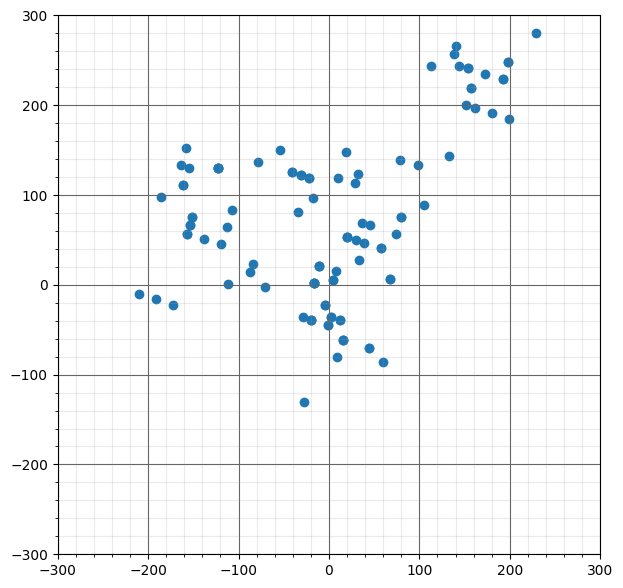

<IPython.core.display.Javascript object>

In [372]:
scatter_plot(xs_filt, ys_filt, lim=(-300, 300))